In [53]:
# Standard imports
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as mpl
import matplotlib.cm as cm
import pandas as pd
import os
from scipy import interpolate as interp
mpl.rcParams['font.size'] = 12

## Define the given parameters 

In [54]:
f_0 = 5.4*10**9   # Hz
ground_range_res = 5   # m
azim_res = 20   # m
incidence = np.radians (np.linspace (32, 40, 100))   # radians 
NESZ = -26   # dB
sigma_h = 0.015   # m
temp = 10   # celcius 
sand_frac = 0.51
clay_frac = 0.14
bulk_dens = 1.54   # g/cm^3
NDVI = np.linspace (0.1, 0.8, 100)
m_v = 0.2

## Assignment 1

In [55]:
# Calculate the dielectric constant of soil based on the previous assignment
def dielectric_water(f, T):
    e_inf = 4.9
    e_w0 = static_dia_water(T)
    rt = chill_t_water(T)

    test=e_inf+(e_w0-e_inf)/(1+np.pi*f*rt*2j)
    e_real=np.real(test)
    e_imag=np.imag(test)

    return e_real, e_imag

def chill_t_water(T):
    relax_t = (1.1109e-10 - 3.824e-12*T + 6.938e-14*T**2 - 5.096e-16*T**3) / (2*np.pi) # T in C
    return relax_t

def static_dia_water(T):
    e_w0 = 88.045 - 0.4147*T + 6.295*1e-4*T**2 + 1.075e-5*T**3
    return e_w0

def soil_dialectric (T,frq,mv,S,C,rho_bulk = 1.54):

    # Get the values for water that is in the soil
    water_real,water_imaginary=dielectric_water(frq,T)

    e_w0 = static_dia_water(T)


    # Empirical relations for soil values
    alpha = 0.65
    beta_1 = 1.27 - 0.519*S - 0.152 * C
    beta_2 = 2.06 - 0.928*S - 0.255 * C
    sigma_eff = -1.645 +1.939*rho_bulk - 2.256 * S +1.594*C

    #Need to add the extra term in the imaginary part of water to compensate for the soil texture

    extra_term = (2.65-rho_bulk)/(2.65*mv) * sigma_eff/(2*np.pi*e_w0*frq)
    water_imaginary+=extra_term

    real_soil=(1+0.66*rho_bulk+mv**(beta_1) *water_real**(alpha) -mv )**(1/alpha)
    imaginary_soil=mv**(beta_2)*water_imaginary

    return real_soil, imaginary_soil

# Calculate the real and imaginary parts of the dielectric constant
real,imag = soil_dialectric (temp, f_0, m_v, sand_frac, clay_frac)

In [56]:
# Small perturbation model
def GaussianSpectrum(kx, ky, sigma_h, l):
    # Do something... ideally your code works with both single values or with vectors or arrays
    # Here some dummy wrong code just to make an example plot
    S_G = sigma_h**2*(l**2/np.pi)*np.exp(-(kx**2+ky**2)*l**2/4)
    S_e = sigma_h**2 * (2*l**2)/(np.pi*(1+(kx**2+ky**2)*l**2)**(3/2))
    return S_G,S_e

def NRCS_SMP(f, theta_i, epsilon_r, spec_f, sigma_h, l):
    
    c=3*10**8
    lambda_0=c/f

    k_B = (2*np.pi)/(lambda_0/(2*np.sin(theta_i)))   
    k_0=k_B/(2*np.sin(theta_i))

    
    # rest of your code
    alpha_vv = (epsilon_r-1)*((epsilon_r-1)*(np.sin(theta_i)**2)+epsilon_r)/((epsilon_r*np.cos(theta_i))+np.sqrt(epsilon_r-(np.sin(theta_i)**2)))**2
    alpha_hh = (epsilon_r-1)/(np.cos(theta_i)+np.sqrt(epsilon_r-(np.sin(theta_i)**2)))

    _,S = spec_f(2*k_0*np.sin(theta_i), 0, sigma_h, l)

    NRCS_hh=4*np.pi*k_0**4 *np.cos(theta_i)**4 *np.abs(alpha_hh)**2 *S
    NRCS_vv=4*np.pi*k_0**4 *np.cos(theta_i)**4 *np.abs(alpha_vv)**2 *S

    return NRCS_hh, NRCS_vv

In [57]:
# Calculate the required autocorrelation length
angle_ex1 = np.radians (40)
hh1, vv1 = NRCS_SMP (f_0, angle_ex1, real, GaussianSpectrum, sigma_h, 4.4)
print (f"For l=3.0 sigma_vv is {vv1:.4f}")

For l=3.0 sigma_vv is 0.0101


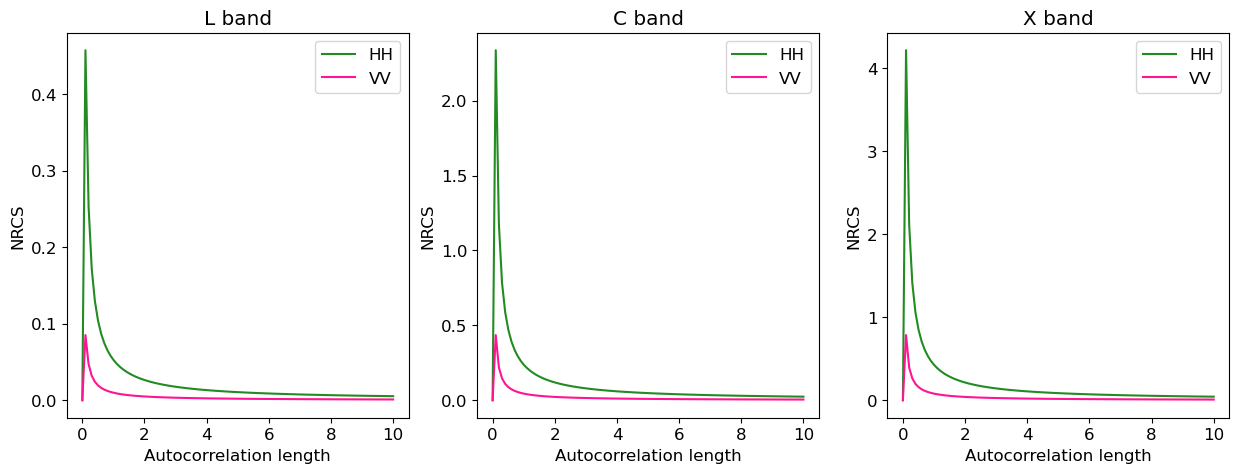

In [77]:
# Plot the NRCS as a function of autocorrelation length
l_array = np.linspace (0, 10, 100)

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))

# L band - 1.2 GHz
hhL, vvL = NRCS_SMP (1.2*10**9, angle_ex1, real, GaussianSpectrum, sigma_h, l_array)
ax1.plot (l_array, hhL, color='forestgreen', label='HH')
ax1.plot (l_array, vvL, color='deeppink', label='VV')
ax1.set_title ('L band')
ax1.set_xlabel ('Autocorrelation length')
ax1.set_ylabel ('NRCS')
ax1.legend ()

# C band - 5.4 GHz
hhC, vvC = NRCS_SMP (5.4*10**9, angle_ex1, real, GaussianSpectrum, sigma_h, l_array)
ax2.plot (l_array, hhC, color='forestgreen', label='HH')
ax2.plot (l_array, vvC, color='deeppink', label='VV')
ax2.set_title ('C band')
ax2.set_xlabel ('Autocorrelation length')
ax2.set_ylabel ('NRCS')
ax2.legend ()

# X band - 9.7 GHz
hhX, vvX = NRCS_SMP (9.7*10**9, angle_ex1, real, GaussianSpectrum, sigma_h, l_array)
ax3.plot (l_array, hhX, color='forestgreen', label='HH')
ax3.plot (l_array, vvX, color='deeppink', label='VV')
ax3.set_title ('X band')
ax3.set_xlabel ('Autocorrelation length')
ax3.set_ylabel ('NRCS')
ax3.legend ()


## Assignment 2

Text(0, 0.5, 'VV NRCS')

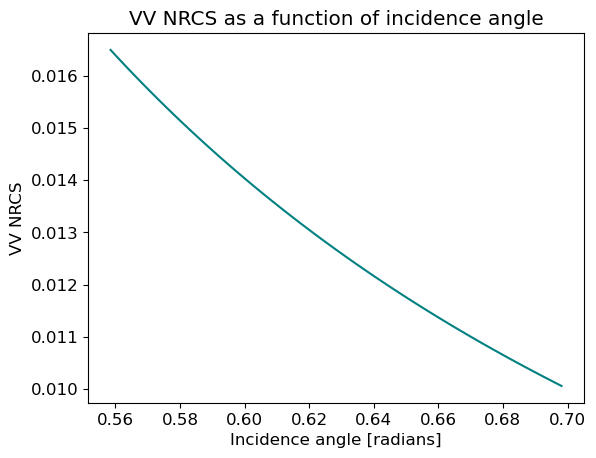

In [59]:
# Plot the VV against incidence angle 
hh2, vv2 = NRCS_SMP (f_0, incidence, real, GaussianSpectrum, sigma_h, 4.4)
plt.plot(incidence, vv2, color='teal')
plt.title('VV NRCS as a function of incidence angle')
plt.xlabel ('Incidence angle [radians]')
plt.ylabel ('VV NRCS')

## Assignment 3

In [60]:
# Combine the surface scattering component with the paper
# Define parameters from paper
A_VV = 0.0950
A_VH = 0.0413
B_VV = 0.5513
B_VH = 1.1662
V = NDVI

# Incidence angle = 32 degrees 

# m_v = 0.1
theta1 = np.radians (32)

# Calculate NRCS VV
real3a,imag3a = soil_dialectric (temp, f_0, 0.1, sand_frac, clay_frac)
hh32a, vv32a = NRCS_SMP (f_0, theta1, real3a, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh32 = 0

# Calculate sigma_total based on the paper 
T_VV = np.exp (-2*B_VV*V*(1/np.cos(theta1)))
T_VH = np.exp (-2*B_VH*V*(1/np.cos(theta1)))

sigma_veg_VV32 = A_VV * V * np.cos (theta1) * (1-T_VV)
sigma_veg_VH32 = A_VH * V * np.cos (theta1) * (1-T_VH)

sigma_vv32_1 = sigma_veg_VV32 + T_VV * vv32a
sigma_vh32_1 = sigma_veg_VH32 + T_VH * vh32

# m_v = 0.25

# Calculate NRCS VV
real3b,imag3b = soil_dialectric (temp, f_0, 0.25, sand_frac, clay_frac)
hh32b, vv32b = NRCS_SMP (f_0, theta1, real3b, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh32 = 0

# Calculate sigma_total based on the paper 
sigma_vv32_25 = sigma_veg_VV32 + T_VV * vv32b
sigma_vh32_25 = sigma_veg_VH32 + T_VH * vh32

In [61]:
# Incidence angle = 40 degrees 

# m_v = 0.1
theta2 = np.radians (40)

# Calculate NRCS VV
real3a,imag3a = soil_dialectric (temp, f_0, 0.1, sand_frac, clay_frac)
hh40a, vv40a = NRCS_SMP (f_0, theta2, real3a, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh40 = 0

# Calculate sigma_total based on the paper 
T_VV = np.exp (-2*B_VV*V*(1/np.cos(theta2)))
T_VH = np.exp (-2*B_VH*V*(1/np.cos(theta2)))

sigma_veg_VV40 = A_VV * V * np.cos (theta1) * (1-T_VV)
sigma_veg_VH40 = A_VH * V * np.cos (theta1) * (1-T_VH)

sigma_vv40_1 = sigma_veg_VV40 + T_VV * vv40a
sigma_vh40_1 = sigma_veg_VH40 + T_VH * vh40

# m_v = 0.25

# Calculate NRCS VV
real3b,imag3b = soil_dialectric (temp, f_0, 0.25, sand_frac, clay_frac)
hh40b, vv40b = NRCS_SMP (f_0, theta2, real3b, GaussianSpectrum, sigma_h, 4.4)

# NRCS VH = 0
vh40 = 0

# Calculate sigma_total based on the paper 
sigma_vv40_25 = sigma_veg_VV40 + T_VV * vv40b
sigma_vh40_25 = sigma_veg_VH40 + T_VH * vh40

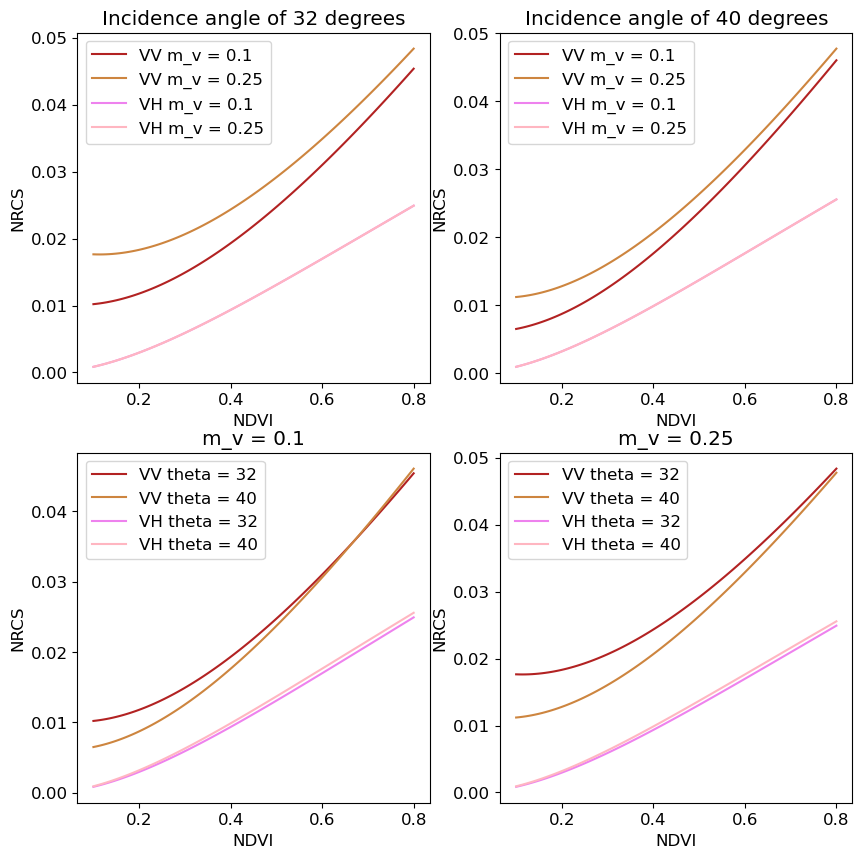

In [67]:
# Make the plots 
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten() 

ax1.plot (NDVI, sigma_vv32_1, color='firebrick', label='VV m_v = 0.1' )
ax1.plot (NDVI, sigma_vv32_25, color='peru', label='VV m_v = 0.25' )
ax1.plot (NDVI, sigma_vh32_1, color='violet', label='VH m_v = 0.1' )
ax1.plot (NDVI, sigma_vh32_25, color='lightpink', label='VH m_v = 0.25' )
ax1.set_title ('Incidence angle of 32 degrees')
ax1.set_xlabel ('NDVI')
ax1.set_ylabel ('NRCS')
ax1.legend ()

ax2.plot (NDVI, sigma_vv40_1, color='firebrick', label='VV m_v = 0.1' )
ax2.plot (NDVI, sigma_vv40_25, color='peru', label='VV m_v = 0.25' )
ax2.plot (NDVI, sigma_vh40_1, color='violet', label='VH m_v = 0.1' )
ax2.plot (NDVI, sigma_vh40_25, color='lightpink', label='VH m_v = 0.25' )
ax2.set_title ('Incidence angle of 40 degrees')
ax2.set_xlabel ('NDVI')
ax2.set_ylabel ('NRCS')
ax2.legend ()

ax3.plot (NDVI, sigma_vv32_1, color='firebrick', label='VV theta = 32' )
ax3.plot (NDVI, sigma_vv40_1, color='peru', label='VV theta = 40' )
ax3.plot (NDVI, sigma_vh32_1, color='violet', label='VH theta = 32' )
ax3.plot (NDVI, sigma_vh40_1, color='lightpink', label='VH theta = 40' )
ax3.set_title ('m_v = 0.1')
ax3.set_xlabel ('NDVI')
ax3.set_ylabel ('NRCS')
ax3.legend ()

ax4.plot (NDVI, sigma_vv32_25, color='firebrick', label='VV theta = 32' )
ax4.plot (NDVI, sigma_vv40_25, color='peru', label='VV theta = 40' )
ax4.plot (NDVI, sigma_vh32_25, color='violet', label='VH theta = 32' )
ax4.plot (NDVI, sigma_vh40_25, color='lightpink', label='VH theta = 40' )
ax4.set_title ('m_v = 0.25')
ax4.set_xlabel ('NDVI')
ax4.set_ylabel ('NRCS')
ax4.legend ()

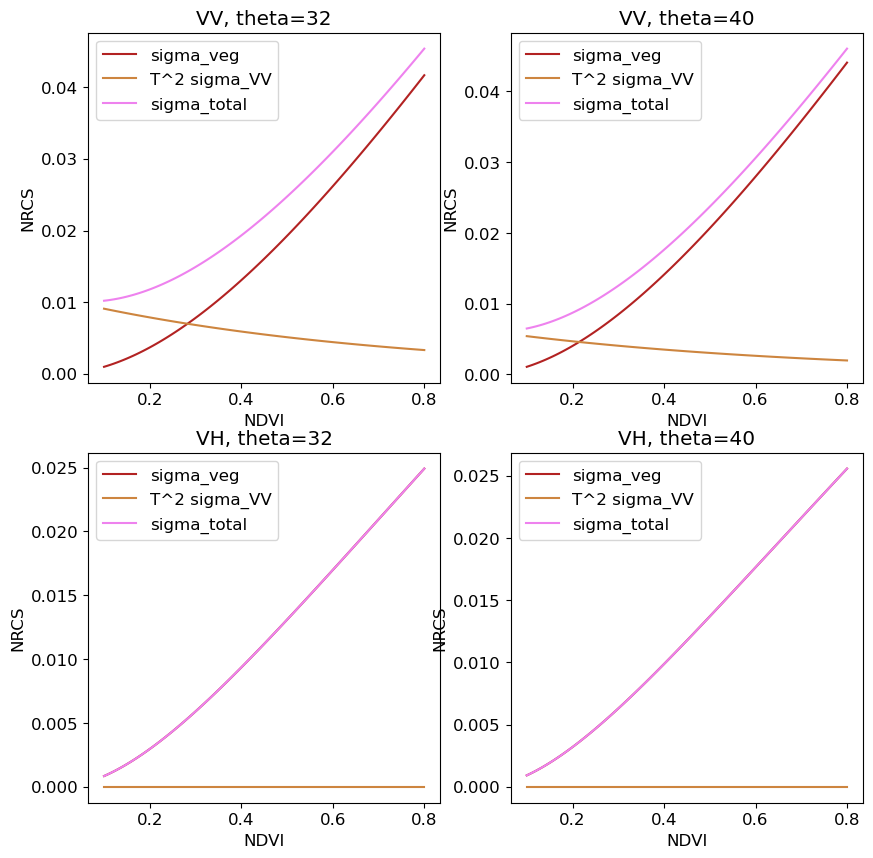

In [72]:
# Make the plots - figure 5 replica m_v = 0.1
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten() 

ax1.plot (NDVI, sigma_veg_VV32, color='firebrick', label='sigma_veg' )
ax1.plot (NDVI, T_VV * vv32a, color='peru', label='T^2 sigma_VV' )
ax1.plot (NDVI, sigma_vv32_1, color='violet', label='sigma_total' )
ax1.set_title ('VV, theta=32')
ax1.set_xlabel ('NDVI')
ax1.set_ylabel ('NRCS')
ax1.legend ()

ax2.plot (NDVI, sigma_veg_VV40, color='firebrick', label='sigma_veg' )
ax2.plot (NDVI, T_VV * vv40a, color='peru', label='T^2 sigma_VV' )
ax2.plot (NDVI, sigma_vv40_1, color='violet', label='sigma_total' )
ax2.set_title ('VV, theta=40')
ax2.set_xlabel ('NDVI')
ax2.set_ylabel ('NRCS')
ax2.legend ()

ax3.plot (NDVI, sigma_veg_VH32, color='firebrick', label='sigma_veg' )
ax3.plot (NDVI, T_VH * vh32, color='peru', label='T^2 sigma_VV' )
ax3.plot (NDVI, sigma_vh32_1, color='violet', label='sigma_total' )
ax3.set_title ('VH, theta=32')
ax3.set_xlabel ('NDVI')
ax3.set_ylabel ('NRCS')
ax3.legend ()

ax4.plot (NDVI, sigma_veg_VH40, color='firebrick', label='sigma_veg' )
ax4.plot (NDVI, T_VH * vh40, color='peru', label='T^2 sigma_VV' )
ax4.plot (NDVI, sigma_vh40_1, color='violet', label='sigma_total' )
ax4.set_title ('VH, theta=40')
ax4.set_xlabel ('NDVI')
ax4.set_ylabel ('NRCS')
ax4.legend ()

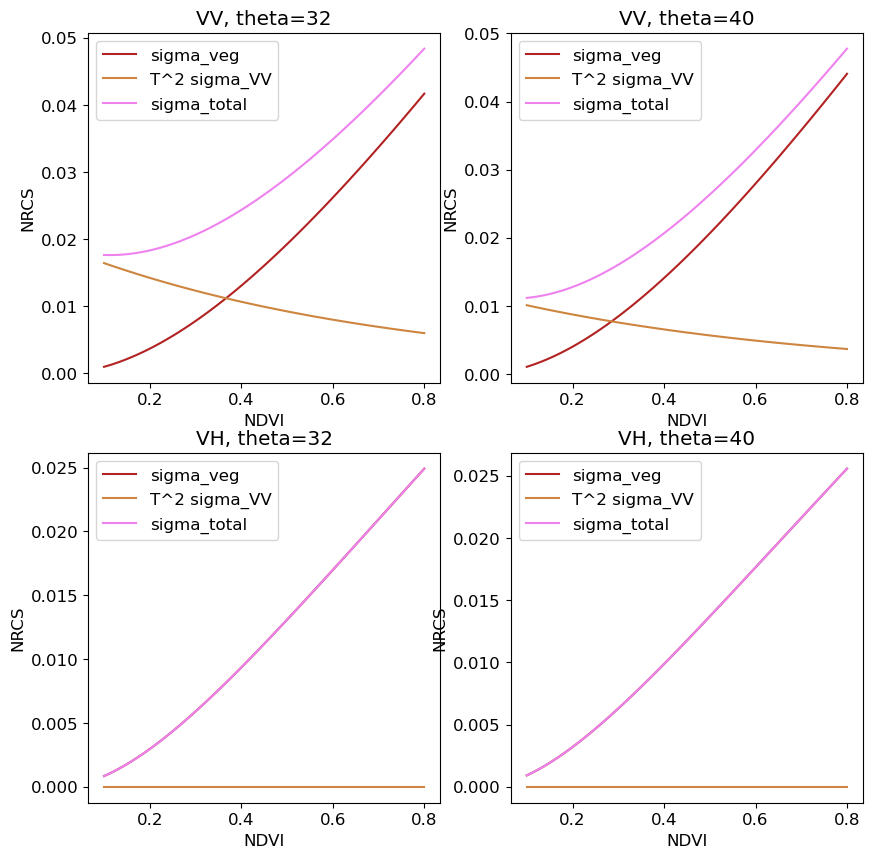

In [73]:
# Make the plots - figure 5 replica m_v = 0.25
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax1, ax2, ax3, ax4 = axes.flatten() 

ax1.plot (NDVI, sigma_veg_VV32, color='firebrick', label='sigma_veg' )
ax1.plot (NDVI, T_VV * vv32b, color='peru', label='T^2 sigma_VV' )
ax1.plot (NDVI, sigma_vv32_25, color='violet', label='sigma_total' )
ax1.set_title ('VV, theta=32')
ax1.set_xlabel ('NDVI')
ax1.set_ylabel ('NRCS')
ax1.legend ()

ax2.plot (NDVI, sigma_veg_VV40, color='firebrick', label='sigma_veg' )
ax2.plot (NDVI, T_VV * vv40b, color='peru', label='T^2 sigma_VV' )
ax2.plot (NDVI, sigma_vv40_25, color='violet', label='sigma_total' )
ax2.set_title ('VV, theta=40')
ax2.set_xlabel ('NDVI')
ax2.set_ylabel ('NRCS')
ax2.legend ()

ax3.plot (NDVI, sigma_veg_VH32, color='firebrick', label='sigma_veg' )
ax3.plot (NDVI, T_VH * vh32, color='peru', label='T^2 sigma_VV' )
ax3.plot (NDVI, sigma_vh32_25, color='violet', label='sigma_total' )
ax3.set_title ('VH, theta=32')
ax3.set_xlabel ('NDVI')
ax3.set_ylabel ('NRCS')
ax3.legend ()

ax4.plot (NDVI, sigma_veg_VH40, color='firebrick', label='sigma_veg' )
ax4.plot (NDVI, T_VH * vh40, color='peru', label='T^2 sigma_VV' )
ax4.plot (NDVI, sigma_vh40_25, color='violet', label='sigma_total' )
ax4.set_title ('VH, theta=40')
ax4.set_xlabel ('NDVI')
ax4.set_ylabel ('NRCS')
ax4.legend ()

## Assignment 4